In [1]:
print("Importing Libraries ...", end = " ")
try:
    import numpy as np
    import pandas as pd
    import random
    import h5py
    import time
    import mne
    import csv
    import os
    from sklearn.preprocessing import scale, minmax_scale, StandardScaler
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import BaggingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import model_selection, svm, metrics
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.utils import shuffle
    from scipy.signal import butter, lfilter, freqz
    from datetime import datetime, timedelta
    from matplotlib.patches import Rectangle
    from matplotlib import pyplot as plt
    from scipy.stats import skew, kurtosis
    from scipy import fftpack
    from scipy import signal
    import pywt
    
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
    from model_dtct_feat import get_model
    from model_dtct_reeg import get_model_reeg
    from model_dtct_cnn_feat import get_model_cnn_feat
    from model_dtct_cnn_reeg import get_model_cnn_reeg
    print("Done!\n")
except Exception as e:
    print("Failed to import one or more packages!\n")
    print(e)
    
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__)

Importing Libraries ... 

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2025-01-10 10:01:43.785543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-10 10:01:44.513476: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 10:01:45.802634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lclhome/umoha

Done!

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [54]:
def list_mean(list_1):
    return sum(list_1)/len(list_1)

def pred_print_and_plot_metrics(results_path, data_path, patient_list, leads_seiz_used_inds_dict,
                                beta = 20, mtype = "res", dtype = "feat", 
                                stype = "vld", tvt_dict = {}):
    
    metrics_dict_tests = {"roc": [], "acc": [], "spe": [], "sen": [], "pre": [], "fpr": [], "f1s": [], "fbs": [], 
                          "fpr_list": [], "tpr_list": []}

    print(f"************************************************* {tvt_dict[stype]} Metrics "
          f"*************************************************")
    print(f"ID/Seiz ROC-AUC \tAccuracy \tSpecificity \tSensitivity \tPrecision \tFPR \t  F-1 \t\t F-beta")  
    
    for cur_pat_id in patient_list:
        pass
    for i in range(num_of_bmrks):
        benchmark_id = bnchmrk_names_list[i]
        #npy_file_dirs_dict[benchmark_id] = []
        sph_len_mins = benchmark_tot_list[i][0]
        sop_len_mins = benchmark_tot_list[i][1]
        gap_len_mins = sph_len_mins + sop_len_mins
        f07_bmrk_idnm_strg = benchmark_id # "bmrk{:02d}".format(benchmark_id)
        f08_spht_secs_strg = "sph{:02d}m".format(sph_len_mins)
        f09_sopt_secs_strg = "sop{:02d}m".format(sop_len_mins)
        benchmark_prefix = (f"{f07_bmrk_idnm_strg}_{f08_spht_secs_strg}_{f09_sopt_secs_strg}_"
                            f"{f10_segs_lens_strg}_{f11_over_stat_strg}")
    
        for j in range(1):
            valid_seizure_number = j
            vald_seiz_strg = f07_bmrk_idnm_strg
            dkey = f07_bmrk_idnm_strg
        
            trn_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}"
            trn_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_labels_suffix}"
            vld_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_values_suffix}"
            vld_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_labels_suffix}"
        
            trn_labs_fpath =  pth_upl+trn_labs_fname
            vld_labs_fpath =  pth_upl+vld_labs_fname
            y_prob_tests = np.load(f'{results_path}{dkey}_{stype}_pred_{mtype}_{dtype}_output.npy')
            if stype == "vld":
                y_valid_read_csv = pd.read_csv(vld_labs_fpath, header=None, index_col = None)
                y_true_tests = y_valid_read_csv.values.squeeze()
            else:
                y_train_read_csv = pd.read_csv(trn_labs_fpath, header=None, index_col = None)
                y_true_tests = y_train_read_csv.values.squeeze()

    
            fpr_list_tests, tpr_list_tests, thr_list_tests = metrics.roc_curve(y_true_tests,y_prob_tests)
            pre_list_tests, rec_list_tests, thr_list_tests = metrics.precision_recall_curve(y_true_tests, y_prob_tests)
            f1_score_tests = (1+beta**2) * (pre_list_tests * rec_list_tests) / ((pre_list_tests*beta**2) + 
                                                                                rec_list_tests + np.finfo(float).eps)
            f1_max_ind_tests = np.argmax(f1_score_tests)
            #threshold_tests = thr_list_tests[f1_max_ind_tests]
            if mtype in ["res", "cnn", "rnn"]:
                threshold_tests = thr_list_tests[f1_max_ind_tests]
                threshold_tests = 0.5
            else:
                threshold_tests = 0.5
            y_pred_tests = y_prob_tests >= threshold_tests
            cm = metrics.confusion_matrix(y_true_tests,y_pred_tests)
            tp_list_tests = cm[1,1]
            fp_list_tests = cm[0,1]
            tn_list_tests = cm[0,0]
            fn_list_tests = cm[1,0]
    
            
            spe_tests = tn_list_tests/(tn_list_tests+fp_list_tests + np.finfo(float).eps)
            sen_tests = tp_list_tests/(tp_list_tests+fn_list_tests + np.finfo(float).eps)
            acc_tests = 0.5*(sen_tests+spe_tests)
            pre_tests = tp_list_tests/(tp_list_tests+fp_list_tests + np.finfo(float).eps)
            fpr_tests = fp_list_tests/(tn_list_tests+fp_list_tests + np.finfo(float).eps)
            roc_tests = metrics.roc_auc_score(y_true_tests, y_prob_tests)
            f1s_tests = 2 * (pre_tests * sen_tests) / (pre_tests + sen_tests + np.finfo(float).eps)
            fbs_tests = (1+beta**2) * (pre_tests * sen_tests) / ((pre_tests*beta**2) + sen_tests + np.finfo(float).eps)
    
            metrics_dict_tests["roc"].append(roc_tests)
            metrics_dict_tests["acc"].append(acc_tests)
            metrics_dict_tests["spe"].append(spe_tests)
            metrics_dict_tests["sen"].append(sen_tests)
            metrics_dict_tests["pre"].append(pre_tests)
            metrics_dict_tests["fpr"].append(fpr_tests)
            metrics_dict_tests["f1s"].append(f1s_tests)
            metrics_dict_tests["fbs"].append(fbs_tests)
            metrics_dict_tests["fpr_list"].append(fpr_list_tests)
            metrics_dict_tests["tpr_list"].append(tpr_list_tests)
    
            roc_tests = metrics_dict_tests["roc"][-1]
            acc_tests = metrics_dict_tests["acc"][-1]
            spe_tests = metrics_dict_tests["spe"][-1]
            sen_tests = metrics_dict_tests["sen"][-1]
            pre_tests = metrics_dict_tests["pre"][-1]
            fpr_tests = metrics_dict_tests["fpr"][-1]
            f1s_tests = metrics_dict_tests["f1s"][-1]
            fbs_tests = metrics_dict_tests["fbs"][-1]
    
            print('{:s} S{:02d}'.format((dkey[-2:]), valid_seizure_number), end = " ")
            print('\t{:6.2f}%'.format(100*roc_tests), end = " ")
            print('\t{:6.2f}%'.format(100*acc_tests), end = " ")
            print('\t{:6.2f}%'.format(100*spe_tests), end = " ")
            print('\t{:6.2f}%'.format(100*sen_tests), end = " ")
            print('\t{:6.2f}%'.format(100*pre_tests), end = " ")
            print('     {:6.2f}%'.format(100*fpr_tests), end = " ")
            print('\t{:6.2f}%'.format(100*f1s_tests), end = " ")
            print('\t{:6.2f}%'.format(100*fbs_tests), end = " ")
            print()

    metrics_dict_tests["roc"].append(list_mean(metrics_dict_tests["roc"]))
    metrics_dict_tests["acc"].append(list_mean(metrics_dict_tests["acc"]))
    metrics_dict_tests["spe"].append(list_mean(metrics_dict_tests["spe"]))
    metrics_dict_tests["sen"].append(list_mean(metrics_dict_tests["sen"]))
    metrics_dict_tests["pre"].append(list_mean(metrics_dict_tests["pre"]))
    metrics_dict_tests["fpr"].append(list_mean(metrics_dict_tests["fpr"]))
    metrics_dict_tests["f1s"].append(list_mean(metrics_dict_tests["f1s"]))
    metrics_dict_tests["fbs"].append(list_mean(metrics_dict_tests["fbs"]))
    metrics_dict_tests["fpr_list"].append([])
    metrics_dict_tests["tpr_list"].append([])
    print('{:s}'.format("Avgs."), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["roc"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["acc"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["spe"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["sen"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["pre"][-1]), end = " ")
    print('     {:6.2f}%'.format(100*metrics_dict_tests["fpr"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["f1s"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["fbs"][-1]), end = " ")
        
    return metrics_dict_tests

In [25]:
def create_directory(path_name, directory_name = '', description = None, verbose = True):
    if not description:
        description = directory_name
    path_name = path_name + directory_name
    if not os.path.isdir(path_name):
        if verbose:
            print(f"Creating {description} directory ...", end =" ")
        try:
            os.mkdir(path_name)
            if verbose:
                print("Done! Directory Created.")
        except:
            print("Could not create directory!")
    else:
        if verbose:
            print(f"{description} directory exists!")
    return path_name

In [26]:
pth_upl = "/disk/raptor-array/SaeedLab-Data/EEG/epilepsy/tuh_eeg_v01/fld_sng/"
num_of_features = 1420
smp_rte_secs = 256
win_len_secs = 5
num_of_chans = 20
smps_per_win = win_len_secs*smp_rte_secs
smps_2d_size = num_of_chans*smps_per_win
ovr_len_secs = 0
crss_val_fld = 0


f01_dset_name_strg = "tuhszr"

f02_dtyp_intr_strg = "interm"
f02_dtyp_sfld_strg = "sngfld"
f02_dtyp_mfld_strg = "mltfld"

f03_scld_unsc_strg = "unscld"
f03_scld_nrm1_strg = "norm1d"
f03_scld_nrm2_strg = "norm2d"
f03_scld_mnmx_strg = "minmax"

f04_filt_stat_strg = "unfilt"

f05_blnc_strm_strg = "blcdet"
f05_blnc_rand_strg = "blcrnd"

f06_srat_strg_strg = "srate{:d}Hz".format(smp_rte_secs)

f10_segs_lens_strg = "seg{:02d}s".format(win_len_secs)
f11_over_stat_strg = "ovr{:02d}s".format(ovr_len_secs)

f12_tusz_strd_strg = "tuhstd"
f12_strt_strd_strg = "strtfd"
#f12_psid_nmbr_strg = "{:3s}{:3s}".format(patient_idno, session_idno)

f13_cval_fold_strg = "fold{0:02d}".format(crss_val_fld)
#f13_szrs_nmbr_strg = "szr{:03d}".format(seizure_nmbr)

f14_trns_labl_strg = 'train'
f14_vlds_labl_strg = 'valid'
f14_tsts_labl_strg = 'tests'

f15_vals_labl_strg = 'values'
f15_labs_labl_strg = 'labels'

f16_feat_hdf5_strg = 'hdf5'
f16_feat_nmpy_strg = 'npy'
f16_labs_frmt_strg = 'csv' 

prefix_unsc_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_unsc_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_nrm1_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm1_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_nrm2_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm2_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_mnmx_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_mnmx_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_unsc_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_unsc_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_nrm1_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm1_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_nrm2_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm2_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_mnmx_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_mnmx_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")


train_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_trns_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
train_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_trns_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")
valid_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_vlds_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
valid_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_vlds_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")
tests_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_tsts_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
tests_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_tsts_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")

values_suffix = f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}"
labels_suffix = f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}"

In [27]:
benchmark_sph_list = [2, 5, 15, 30]
benchmark_sop_list = [1, 2, 5]
benchmark_tot_list = [(a, b) for a in benchmark_sph_list for b in benchmark_sop_list]
bnchmrk_names_list =[f"bmrk{1+i:02d}" for i in range(len(benchmark_tot_list))]
num_of_bmrks = len(bnchmrk_names_list)
preferred_gap_times_mins_list = [x[0] + x[1] for x in benchmark_tot_list]
print(benchmark_tot_list)
print(preferred_gap_times_mins_list)
print(bnchmrk_names_list)
print(sorted(set(preferred_gap_times_mins_list))+[45, 60, 90, 120])

[(2, 1), (2, 2), (2, 5), (5, 1), (5, 2), (5, 5), (15, 1), (15, 2), (15, 5), (30, 1), (30, 2), (30, 5)]
[3, 4, 7, 6, 7, 10, 16, 17, 20, 31, 32, 35]
['bmrk01', 'bmrk02', 'bmrk03', 'bmrk04', 'bmrk05', 'bmrk06', 'bmrk07', 'bmrk08', 'bmrk09', 'bmrk10', 'bmrk11', 'bmrk12']
[3, 4, 6, 7, 10, 16, 17, 20, 31, 32, 35, 45, 60, 90, 120]


In [28]:
pth_upl = '/path/to/MLSPred-Bench/fld_sng/'
base_path = create_directory("/base/directory/", description = "Base")
raw_data_path = create_directory(base_path, "raw_data/", description = "Raw Data")
preprocessed_data_path = create_directory(base_path, "dtct_data/", description = "Detection data")
prediction_data_path = create_directory(base_path, "pred_data/", description = "Prediction data")
results_path = create_directory(base_path, "results/", description = "Detection results")
pred_results_path = create_directory(base_path, "results_pred/", description = "Prediction results")
final_scores_path = create_directory(base_path, "scores/", description = "Scores")

Base directory exists!
Raw Data directory exists!
Detection data directory exists!
Prediction data directory exists!
Detection results directory exists!
Prediction results directory exists!
Scores directory exists!


In [33]:
trn_vld_tst_key_list = ["Training", "Validation", "Testing"]
trn_vld_tst_key_dict = {"trn": "Training", "vld": "Validation", "tst": "Testing"}
ml_keys = ['log', 'svm', 'nvb', 'knn', 'dtr', 'lda', 'rfc', 'ada', 'bag', 'res', 'cnn']
score_keys = ['roc', 'acc', 'spe', 'sen', 'pre', 'fpr', 'f1s', 'fbs']
keys_to_include = ['roc', 'acc', 'spe', 'sen', 'pre', 'fpr', 'f1s', 'fbs']
print(ml_keys)
res_dict_tst_feat = {}
dtype = "feat"
for mkey in ml_keys:
    res_dict_tst_feat[mkey] = pred_print_and_plot_metrics(results_path = results_path, data_path = pth_upl, 
                                                          patient_list = bnchmrk_names_list,  
                                                          leads_seiz_used_inds_dict = {},
                                                          beta = 1, mtype = mkey, dtype = dtype, 
                                                          stype = "vld", tvt_dict = trn_vld_tst_key_dict)
    filtered_data = {skey: res_dict_tst_feat[mkey][skey] for skey in keys_to_include}
    res_df = pd.DataFrame(filtered_data)
    res_df.to_csv(final_scores_path + f"pred_{mkey}_{dtype}.csv", index = None)

['log', 'svm', 'nvb', 'knn', 'dtr', 'lda', 'rfc', 'ada', 'bag', 'res', 'cnn']
************************************************* Validation Metrics *************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 67.77% 	 64.16% 	 51.31% 	 77.01% 	 61.27%       48.69% 	 68.24% 	 68.24% 
02 S00 	 63.15% 	 62.61% 	 49.74% 	 75.48% 	 60.03%       50.26% 	 66.87% 	 66.87% 
03 S00 	 71.15% 	 65.75% 	 56.55% 	 74.95% 	 63.30%       43.45% 	 68.64% 	 68.64% 
04 S00 	 73.89% 	 68.33% 	 62.28% 	 74.39% 	 66.35%       37.72% 	 70.14% 	 70.14% 
05 S00 	 75.38% 	 69.25% 	 63.76% 	 74.74% 	 67.34%       36.24% 	 70.85% 	 70.85% 
06 S00 	 72.82% 	 65.75% 	 56.05% 	 75.45% 	 63.19%       43.95% 	 68.78% 	 68.78% 
07 S00 	 75.73% 	 69.24% 	 68.70% 	 69.79% 	 69.04%       31.30% 	 69.41% 	 69.41% 
08 S00 	 77.01% 	 70.01% 	 70.99% 	 69.03% 	 70.41%       29.01% 	 69.72% 	 69.72% 
09 S00 	 76.67% 	 68.25% 	 68.32% 	 68.18% 	 6

05 S00 	 73.45% 	 68.04% 	 59.48% 	 76.59% 	 65.40%       40.52% 	 70.55% 	 70.55% 
06 S00 	 76.45% 	 70.18% 	 59.81% 	 80.55% 	 66.72%       40.19% 	 72.98% 	 72.98% 
07 S00 	 77.62% 	 71.23% 	 68.49% 	 73.97% 	 70.13%       31.51% 	 72.00% 	 72.00% 
08 S00 	 80.08% 	 73.41% 	 73.67% 	 73.15% 	 73.53%       26.33% 	 73.34% 	 73.34% 
09 S00 	 80.05% 	 70.14% 	 72.75% 	 67.52% 	 71.25%       27.25% 	 69.34% 	 69.34% 
10 S00 	 63.30% 	 58.56% 	 64.97% 	 52.15% 	 59.82%       35.03% 	 55.72% 	 55.72% 
11 S00 	 88.27% 	 84.88% 	 73.33% 	 96.42% 	 54.65%       26.67% 	 69.77% 	 69.77% 
12 S00 	 63.87% 	 60.67% 	 60.39% 	 60.94% 	 60.61%       39.61% 	 60.78% 	 60.78% 
Avgs. 	 74.76% 	 68.50% 	 61.81% 	 75.19% 	 64.41%       38.19% 	 68.83% 	 68.83% ************************************************* Validation Metrics *************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 71.43% 	 66.22% 	 57.07% 	 75.37%

In [41]:
score_keys = ['roc', 'acc', 'spe', 'sen', 'pre', 'fpr', 'f1s', 'fbs']
keys_to_include = ['roc', 'acc', 'spe', 'sen', 'pre', 'fpr', 'f1s', 'fbs']
res_dict_tst = {}

for mkey in ml_keys:
    res_dict_tst[mkey] = pd.read_csv(final_scores_path+f'pred_{mkey}_feat.csv')

print(f"ID \t  Log \t  SVM \t  NVB \t  kNN \t  DTR \t  LDA \t  RFC \t  ADA \t  Bag \t ResNet\t  CNN") 
score_summary_dict = {}
for skey in score_keys:
    print(skey, end = "\t")
    score_summary_dict[skey] = []
    for mkey in ml_keys:
        score_summary_dict[skey].append(res_dict_tst[mkey][skey].values[-1])
    #score_summary_dict[skey].append(res_dict_tst_res1[skey][-1])
    #score_summary_dict[skey].append(res_dict_tst_res2[skey][-1])
    for score in score_summary_dict[skey]:
        print(f"{100*score:6.2f}%", end = "\t")
    print()
pd.DataFrame(score_summary_dict)

ID 	  Log 	  SVM 	  NVB 	  kNN 	  DTR 	  LDA 	  RFC 	  ADA 	  Bag 	 ResNet	  CNN
roc	 70.29%	 61.93%	 69.28%	 63.88%	 68.28%	 68.98%	 74.76%	 73.73%	 71.66%	 69.90%	 67.48%	
acc	 65.90%	 57.83%	 55.69%	 61.46%	 63.65%	 64.09%	 68.50%	 66.81%	 64.33%	 64.90%	 59.26%	
spe	 59.43%	 31.08%	 89.87%	 49.65%	 58.12%	 57.74%	 61.81%	 64.80%	 42.98%	 55.54%	 55.93%	
sen	 72.36%	 84.58%	 21.51%	 73.28%	 69.19%	 70.44%	 75.19%	 68.83%	 85.68%	 74.27%	 62.59%	
pre	 62.28%	 52.95%	 61.09%	 57.90%	 60.01%	 61.08%	 64.41%	 64.76%	 59.06%	 61.20%	 63.03%	
fpr	 40.57%	 68.92%	 10.13%	 50.35%	 41.88%	 42.26%	 38.19%	 35.20%	 57.02%	 44.46%	 44.07%	
f1s	 66.63%	 64.91%	 24.20%	 64.56%	 63.33%	 65.33%	 68.83%	 66.63%	 69.58%	 66.78%	 56.32%	
fbs	 66.63%	 64.91%	 24.20%	 64.56%	 63.33%	 65.33%	 68.83%	 66.63%	 69.58%	 66.78%	 56.32%	


,roc,acc,spe,sen,pre,fpr,f1s,fbs
0,0.702890,0.658991,0.594339,0.723642,0.622846,0.405661,0.666306,0.666306
1,0.619252,0.578288,0.310819,0.845757,0.529467,0.689181,0.649087,0.649087
2,0.692767,0.556926,0.898720,0.215131,0.610937,0.101280,0.241957,0.241957
3,0.638792,0.614626,0.496493,0.732759,0.578985,0.503507,0.645560,0.645560
4,0.682759,0.636532,0.581199,0.691865,0.600128,0.418801,0.633324,0.633324
5,0.689752,0.640889,0.577381,0.704396,0.610850,0.422619,0.653328,0.653328
6,0.747575,0.684992,0.618090,0.751893,0.644085,0.381910,0.688296,0.688296
7,0.737348,0.668124,0.647960,0.688289,0.647643,0.352040,0.666282,0.666282
8,0.716633,0.643266,0.429753,0.856779,0.590623,0.570247,0.695773,0.695773
9,0.699025,0.649034,0.555412,0.742656,0.612015,0.444588,0.667755,0.667755



ROC curves:


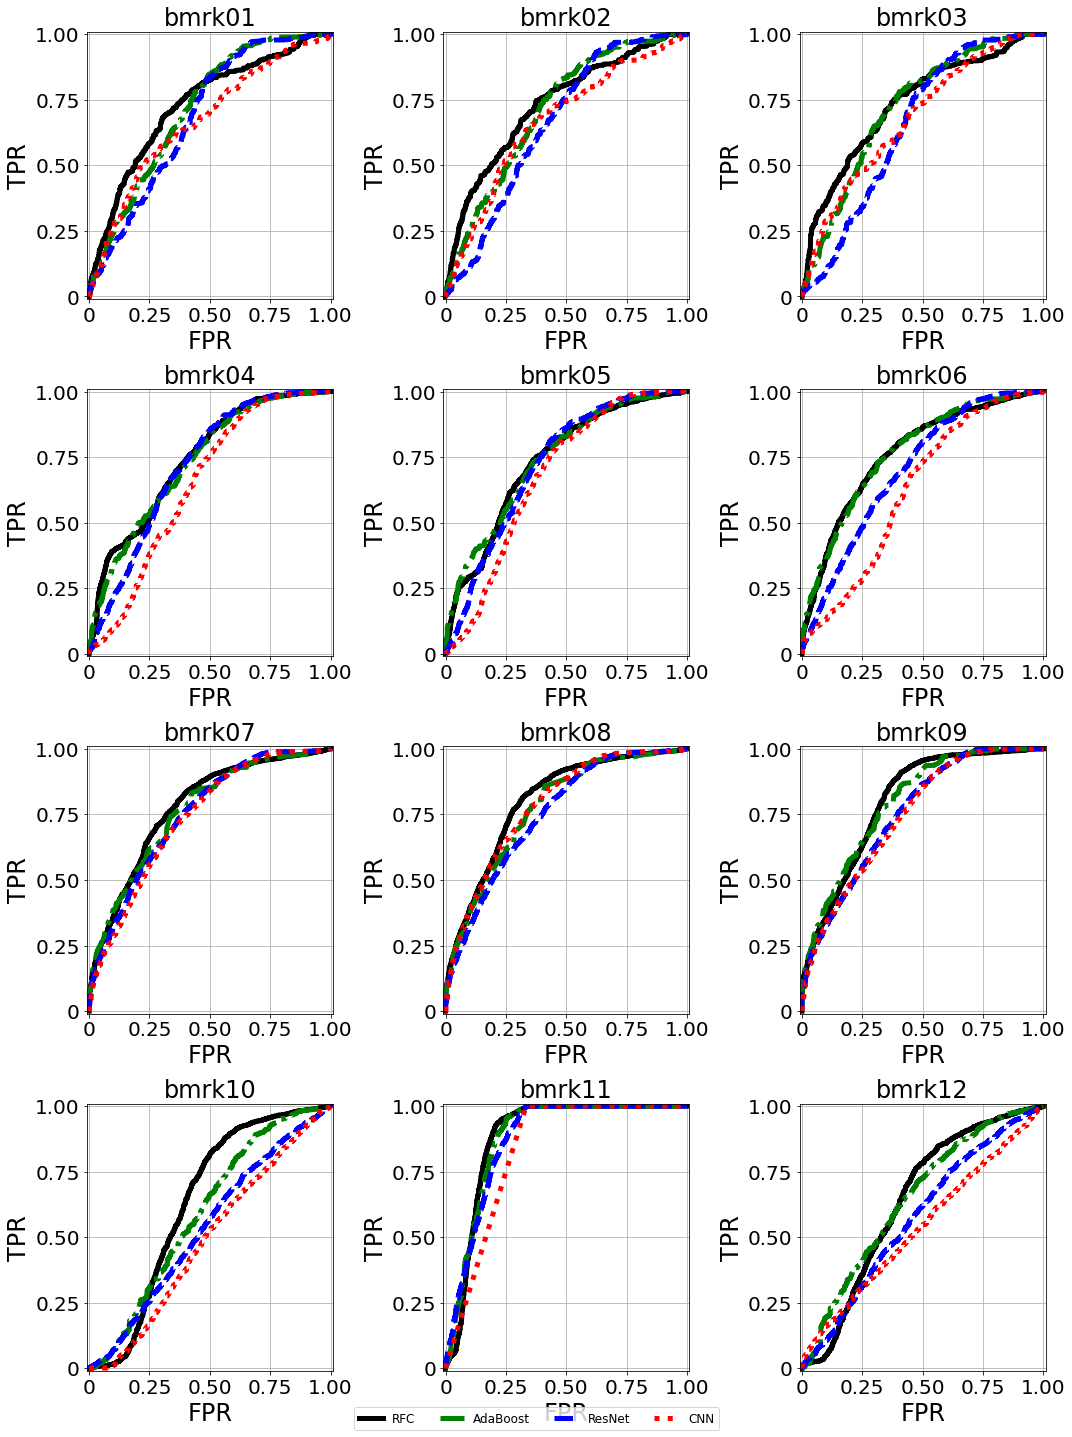

In [58]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(15, 20)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_extra = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_extra = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_rfc, tpr_list_extra, 'k-', linewidth = 5.0)
        ax[ii, jj].plot(fpr_list_ada, tpr_list_ada, 'g-.', linewidth = 5.0)
        ax[ii, jj].plot(fpr_list_res, tpr_list_res, 'b--', linewidth = 5.0)
        ax[ii, jj].plot(fpr_list_cnn, tpr_list_cnn, 'r:', linewidth = 5.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 24)
        ax[ii, jj].set_xlabel('FPR', fontsize = 24)
        ax[ii, jj].set_ylabel('TPR', fontsize = 24)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 20)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 24)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 20)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    print()
    print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["RFC", "AdaBoost", "ResNet", "CNN"], loc = 8, ncol=5, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.0, 0.5, 0.5),  fontsize = 12)
    fig.tight_layout()
    #plt.savefig(fname = "fig03_roc_curves_v01.eps", dpi=300)
    plt.savefig(fname = "mlspred_roc_curves_feat_v01.jpg", dpi=300)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


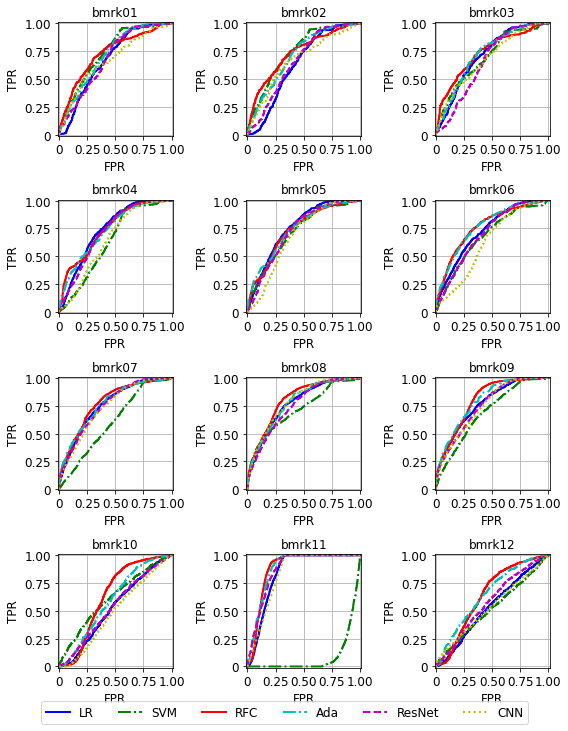

In [66]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(8, 10)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_log, tpr_list_log, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_svm, tpr_list_svm, 'g-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_rfc, tpr_list_rfc, 'r-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_ada, tpr_list_ada, 'c-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_res, tpr_list_res, 'm--', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_cnn, tpr_list_cnn, 'y:', linewidth = 2.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 24)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["LR", "SVM", "RFC", "Ada", "ResNet", "CNN"], loc = 8, ncol=6, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.02, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig03_roc_curves_v01.eps", dpi=300)
    plt.savefig(fname = "mlspred_roc_curves_feat_v01.jpg", dpi=300)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


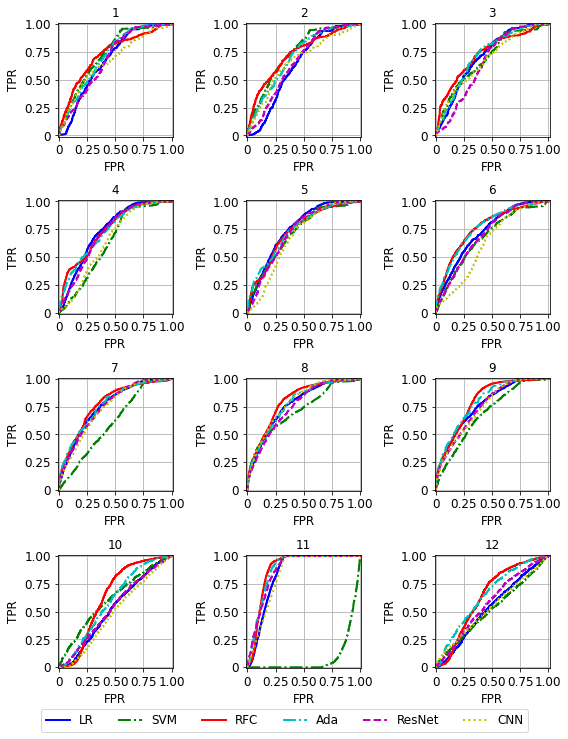

In [72]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(8, 10)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_log, tpr_list_log, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_svm, tpr_list_svm, 'g-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_rfc, tpr_list_rfc, 'r-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_ada, tpr_list_ada, 'c-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_res, tpr_list_res, 'm--', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_cnn, tpr_list_cnn, 'y:', linewidth = 2.0)
        ax[ii, jj].set_title(f'{int(pat_key[-2:]):d}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 24)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["LR", "SVM", "RFC", "Ada", "ResNet", "CNN"], loc = 8, ncol=6, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig03_roc_curves_v01.eps", dpi=300)
    plt.savefig(fname = "mlspred_roc_curves_feat_v01.jpg", dpi=300)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


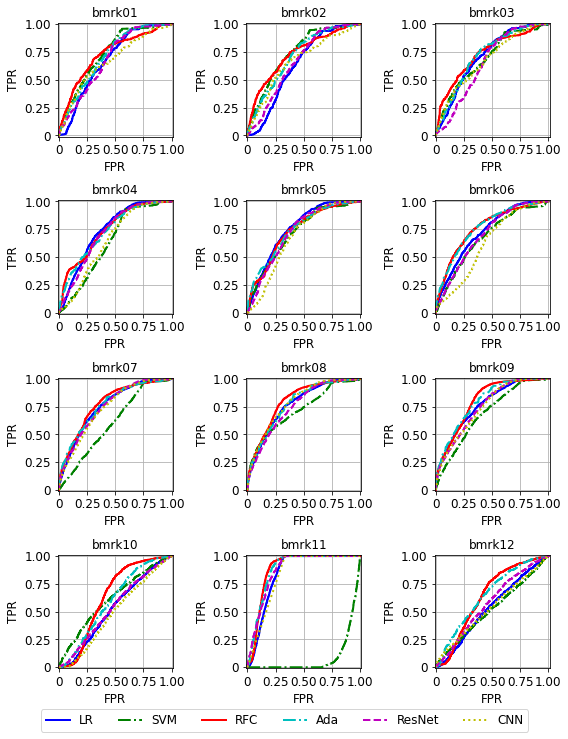

In [69]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(8, 10)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_log, tpr_list_log, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_svm, tpr_list_svm, 'g-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_rfc, tpr_list_rfc, 'r-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_ada, tpr_list_ada, 'c-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_res, tpr_list_res, 'm--', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_cnn, tpr_list_cnn, 'y:', linewidth = 2.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 24)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["LR", "SVM", "RFC", "Ada", "ResNet", "CNN"], loc = 8, ncol=6, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_roc_curves_v01.jpg", dpi=300)
    plt.savefig(fname = "fig04_mlspred_roc_curves_v01.eps", dpi=300)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


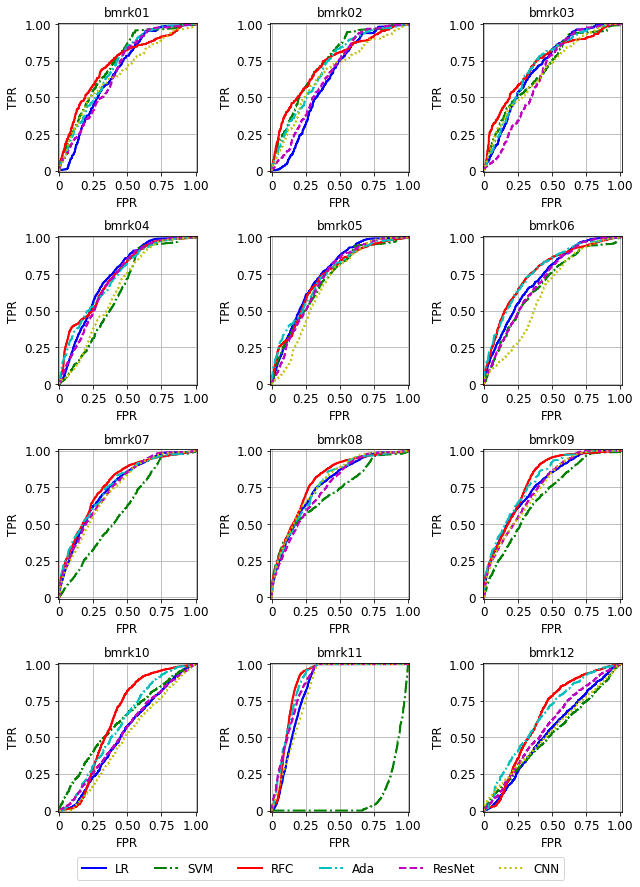

In [81]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(9, 12)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_log, tpr_list_log, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_svm, tpr_list_svm, 'g-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_rfc, tpr_list_rfc, 'r-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_ada, tpr_list_ada, 'c-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_res, tpr_list_res, 'm--', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_cnn, tpr_list_cnn, 'y:', linewidth = 2.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        #ax[ii,jj].set_xlim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_xticks([0.50, 0.75, 1.00])
        #ax[ii,jj].set_xticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["LR", "SVM", "RFC", "Ada", "ResNet", "CNN"], loc = 8, ncol=6, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_roc_curves_v01.jpg", dpi=300)
    plt.savefig(fname = "fig04_mlspred_roc_curves_v01.eps", dpi=300)
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


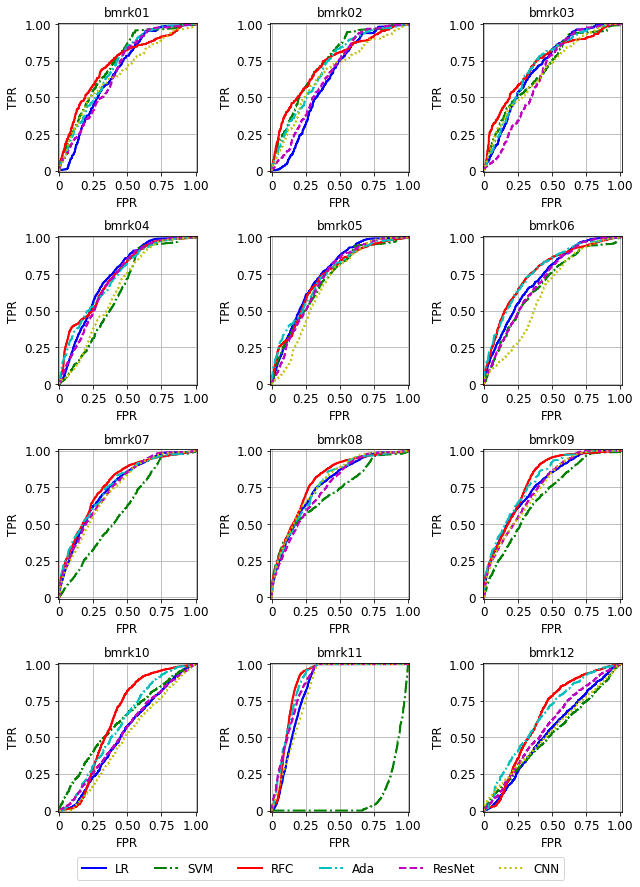

In [83]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(9, 12)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_tst_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_tst_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_tst_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_tst_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_tst_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_tst_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_tst_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_tst_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_tst_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_tst_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_tst_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_tst_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_tst_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_tst_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_tst_log, tpr_list_tst_log, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_svm, tpr_list_tst_svm, 'g-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_rfc, tpr_list_tst_rfc, 'r-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_ada, tpr_list_tst_ada, 'c-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_res, tpr_list_tst_res, 'm--', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_cnn, tpr_list_tst_cnn, 'y:', linewidth = 2.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        #ax[ii,jj].set_xlim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_xticks([0.50, 0.75, 1.00])
        #ax[ii,jj].set_xticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["LR", "SVM", "RFC", "Ada", "ResNet", "CNN"], loc = 8, ncol=6, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_valid_roc_curves_v02.jpg", dpi=300)
    plt.savefig(fname = "fig04_mlspred_valid_roc_curves_v02.eps", dpi=300)
    plt.show()

In [55]:
print(ml_keys)
res_dict_trn_feat = {}
dtype = "feat"
for mkey in ml_keys:
    res_dict_trn_feat[mkey] = pred_print_and_plot_metrics(results_path = results_path, data_path = pth_upl, 
                                                          patient_list = bnchmrk_names_list,  
                                                          leads_seiz_used_inds_dict = {},
                                                          beta = 1, mtype = mkey, dtype = dtype, 
                                                          stype = "trn", tvt_dict = trn_vld_tst_key_dict)
    filtered_data = {skey: res_dict_trn_feat[mkey][skey] for skey in keys_to_include}
    res_df = pd.DataFrame(filtered_data)
    #res_df.to_csv(final_scores_path + f"pred_{mkey}_{dtype}.csv", index = None)

['log', 'svm', 'nvb', 'knn', 'dtr', 'lda', 'rfc', 'ada', 'bag', 'res', 'cnn']
************************************************* Training Metrics *************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 85.88% 	 78.45% 	 78.65% 	 78.25% 	 78.56%       21.35% 	 78.41% 	 78.41% 
02 S00 	 85.61% 	 77.85% 	 77.91% 	 77.79% 	 77.88%       22.09% 	 77.83% 	 77.83% 
03 S00 	 88.26% 	 80.54% 	 80.93% 	 80.14% 	 80.78%       19.07% 	 80.46% 	 80.46% 
04 S00 	 81.40% 	 74.05% 	 73.74% 	 74.36% 	 73.90%       26.26% 	 74.13% 	 74.13% 
05 S00 	 82.42% 	 74.94% 	 75.25% 	 74.64% 	 75.10%       24.75% 	 74.87% 	 74.87% 
06 S00 	 83.30% 	 75.69% 	 75.53% 	 75.85% 	 75.61%       24.47% 	 75.73% 	 75.73% 
07 S00 	 79.42% 	 71.33% 	 74.06% 	 68.60% 	 72.56%       25.94% 	 70.52% 	 70.52% 
08 S00 	 80.14% 	 72.33% 	 75.27% 	 69.38% 	 73.73%       24.73% 	 71.49% 	 71.49% 
09 S00 	 82.39% 	 74.24% 	 77.64% 	 70.85% 	 76.

04 S00 	 86.04% 	 76.80% 	 77.58% 	 76.02% 	 77.22%       22.42% 	 76.62% 	 76.62% 
05 S00 	 86.85% 	 77.99% 	 79.62% 	 76.37% 	 78.93%       20.38% 	 77.63% 	 77.63% 
06 S00 	 88.08% 	 79.59% 	 80.27% 	 78.90% 	 80.00%       19.73% 	 79.44% 	 79.44% 
07 S00 	 83.17% 	 74.66% 	 81.49% 	 67.83% 	 78.56%       18.51% 	 72.80% 	 72.80% 
08 S00 	 84.07% 	 75.19% 	 81.48% 	 68.90% 	 78.81%       18.52% 	 73.52% 	 73.52% 
09 S00 	 85.59% 	 76.77% 	 84.44% 	 69.11% 	 81.62%       15.56% 	 74.85% 	 74.85% 
10 S00 	 95.62% 	 88.43% 	 89.78% 	 87.08% 	 89.49%       10.22% 	 88.27% 	 88.27% 
11 S00 	 97.81% 	 90.27% 	 81.12% 	 99.42% 	 63.71%       18.88% 	 77.65% 	 77.65% 
12 S00 	 95.76% 	 88.54% 	 89.42% 	 87.67% 	 89.23%       10.58% 	 88.44% 	 88.44% 
Avgs. 	 89.50% 	 81.05% 	 82.44% 	 79.66% 	 80.15%       17.56% 	 79.47% 	 79.47% ************************************************* Training Metrics *************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensi

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


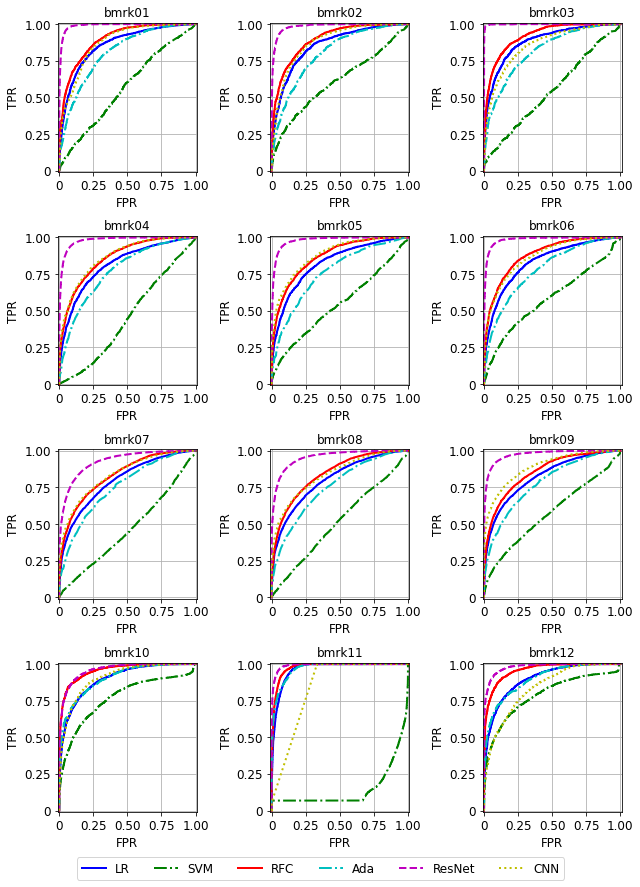

In [84]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(9, 12)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_trn_rfc = res_dict_trn_bag["fpr_list"][iterator]
        #tpr_list_trn_rfc = res_dict_trn_bag["tpr_list"][iterator]
        fpr_list_trn_log = res_dict_trn_feat['log']["fpr_list"][iterator]
        tpr_list_trn_log = res_dict_trn_feat['log']["tpr_list"][iterator]
        fpr_list_trn_svm = res_dict_trn_feat['svm']["fpr_list"][iterator]
        tpr_list_trn_svm = res_dict_trn_feat['svm']["tpr_list"][iterator]
        fpr_list_trn_rfc = res_dict_trn_feat['rfc']["fpr_list"][iterator]
        tpr_list_trn_rfc = res_dict_trn_feat['rfc']["tpr_list"][iterator]
        fpr_list_trn_ada = res_dict_trn_feat['ada']["fpr_list"][iterator]
        tpr_list_trn_ada = res_dict_trn_feat['ada']["tpr_list"][iterator]
        fpr_list_trn_res = res_dict_trn_feat['res']["fpr_list"][iterator]
        tpr_list_trn_res = res_dict_trn_feat['res']["tpr_list"][iterator]
        fpr_list_trn_cnn = res_dict_trn_feat['cnn']["fpr_list"][iterator]
        tpr_list_trn_cnn = res_dict_trn_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_trn_log, tpr_list_trn_log, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_svm, tpr_list_trn_svm, 'g-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_rfc, tpr_list_trn_rfc, 'r-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_ada, tpr_list_trn_ada, 'c-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_res, tpr_list_trn_res, 'm--', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_cnn, tpr_list_trn_cnn, 'y:', linewidth = 2.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        #ax[ii,jj].set_xlim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_xticks([0.50, 0.75, 1.00])
        #ax[ii,jj].set_xticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["LR", "SVM", "RFC", "Ada", "ResNet", "CNN"], loc = 8, ncol=6, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_train_roc_curves_v02.jpg", dpi=300)
    plt.savefig(fname = "fig04_mlspred_train_roc_curves_v02.eps", dpi=300)
    plt.show()

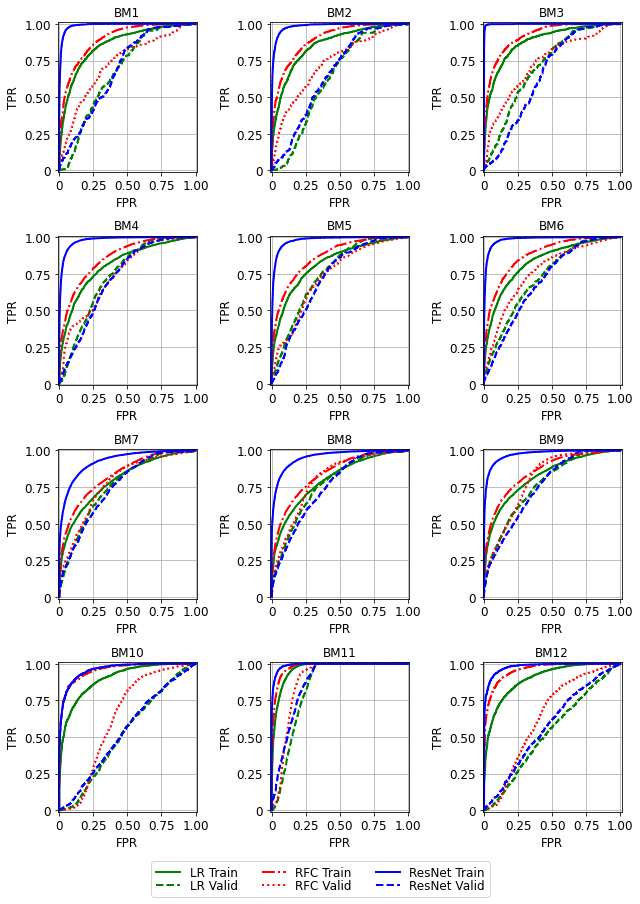

In [105]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(9, 12)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_tst_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_tst_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_trn_log = res_dict_trn_feat['log']["fpr_list"][iterator]
        tpr_list_trn_log = res_dict_trn_feat['log']["tpr_list"][iterator]
        fpr_list_trn_svm = res_dict_trn_feat['svm']["fpr_list"][iterator]
        tpr_list_trn_svm = res_dict_trn_feat['svm']["tpr_list"][iterator]
        fpr_list_trn_rfc = res_dict_trn_feat['rfc']["fpr_list"][iterator]
        tpr_list_trn_rfc = res_dict_trn_feat['rfc']["tpr_list"][iterator]
        fpr_list_trn_ada = res_dict_trn_feat['ada']["fpr_list"][iterator]
        tpr_list_trn_ada = res_dict_trn_feat['ada']["tpr_list"][iterator]
        fpr_list_trn_res = res_dict_trn_feat['res']["fpr_list"][iterator]
        tpr_list_trn_res = res_dict_trn_feat['res']["tpr_list"][iterator]
        fpr_list_trn_cnn = res_dict_trn_feat['cnn']["fpr_list"][iterator]
        tpr_list_trn_cnn = res_dict_trn_feat['cnn']["tpr_list"][iterator]
        fpr_list_tst_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_tst_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_tst_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_tst_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_tst_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_tst_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_tst_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_tst_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_tst_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_tst_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_tst_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_tst_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_trn_log, tpr_list_trn_log, 'g-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_log, tpr_list_tst_log, 'g--', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_rfc, tpr_list_trn_rfc, 'r-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_rfc, tpr_list_tst_rfc, 'r:', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_res, tpr_list_trn_res, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_res, tpr_list_tst_res, 'b--', linewidth = 2.0)
        ax[ii, jj].set_title(f'BM{int(pat_key[-2:])}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        #ax[ii,jj].set_xlim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_xticks([0.50, 0.75, 1.00])
        #ax[ii,jj].set_xticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["LR Train", "LR Valid", "RFC Train", "RFC Valid", "ResNet Train", "ResNet Valid"], 
                  loc = 8, ncol=3, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.05, 0.5, 0.25),  fontsize = 12)
    #plt.figlegend(["LR Train", "LR Valid", "RFC Train", "RFC Valid", "ResNet Train", "ResNet Valid"], 
    #              loc = 8, ncol = 2)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v00.jpg", dpi=300)
    #plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v00.eps", dpi=300)
    plt.show()

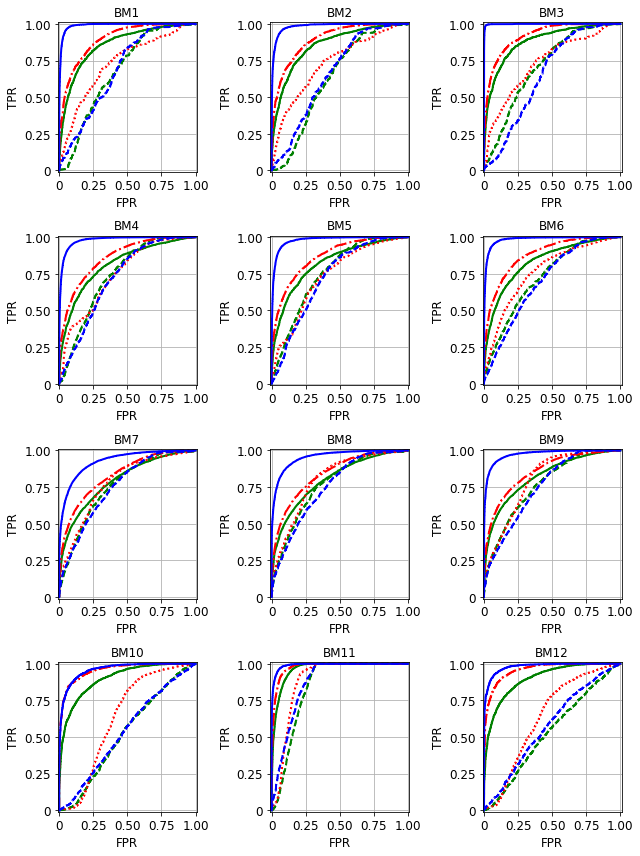

In [106]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(9, 12)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_tst_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_tst_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_trn_log = res_dict_trn_feat['log']["fpr_list"][iterator]
        tpr_list_trn_log = res_dict_trn_feat['log']["tpr_list"][iterator]
        fpr_list_trn_svm = res_dict_trn_feat['svm']["fpr_list"][iterator]
        tpr_list_trn_svm = res_dict_trn_feat['svm']["tpr_list"][iterator]
        fpr_list_trn_rfc = res_dict_trn_feat['rfc']["fpr_list"][iterator]
        tpr_list_trn_rfc = res_dict_trn_feat['rfc']["tpr_list"][iterator]
        fpr_list_trn_ada = res_dict_trn_feat['ada']["fpr_list"][iterator]
        tpr_list_trn_ada = res_dict_trn_feat['ada']["tpr_list"][iterator]
        fpr_list_trn_res = res_dict_trn_feat['res']["fpr_list"][iterator]
        tpr_list_trn_res = res_dict_trn_feat['res']["tpr_list"][iterator]
        fpr_list_trn_cnn = res_dict_trn_feat['cnn']["fpr_list"][iterator]
        tpr_list_trn_cnn = res_dict_trn_feat['cnn']["tpr_list"][iterator]
        fpr_list_tst_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_tst_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_tst_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_tst_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_tst_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_tst_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_tst_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_tst_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_tst_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_tst_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_tst_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_tst_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_trn_log, tpr_list_trn_log, 'g-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_log, tpr_list_tst_log, 'g--', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_rfc, tpr_list_trn_rfc, 'r-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_rfc, tpr_list_tst_rfc, 'r:', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_res, tpr_list_trn_res, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_res, tpr_list_tst_res, 'b--', linewidth = 2.0)
        ax[ii, jj].set_title(f'BM{int(pat_key[-2:])}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        #ax[ii,jj].set_xlim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_xticks([0.50, 0.75, 1.00])
        #ax[ii,jj].set_xticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    #plt.figlegend(["LR Train", "LR Valid", "RFC Train", "RFC Valid", "ResNet Train", "ResNet Valid"], \
    #             loc = 8, ncol=6, labelspacing=0.,
    #             bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v01.jpg", dpi=300)
    #plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v00.eps", dpi=300)
    plt.show()

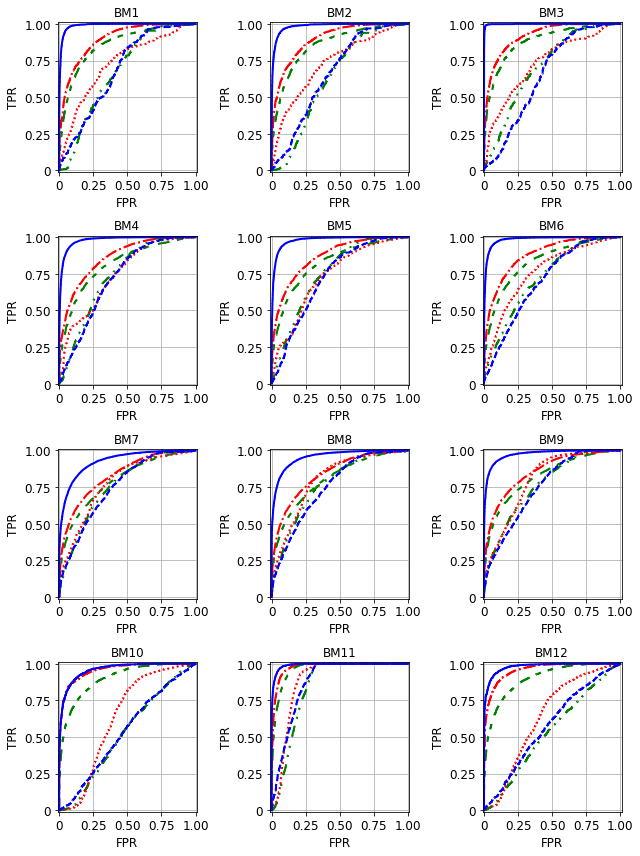

In [124]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(9, 12)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_tst_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_tst_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_trn_log = res_dict_trn_feat['log']["fpr_list"][iterator]
        tpr_list_trn_log = res_dict_trn_feat['log']["tpr_list"][iterator]
        fpr_list_trn_svm = res_dict_trn_feat['svm']["fpr_list"][iterator]
        tpr_list_trn_svm = res_dict_trn_feat['svm']["tpr_list"][iterator]
        fpr_list_trn_rfc = res_dict_trn_feat['rfc']["fpr_list"][iterator]
        tpr_list_trn_rfc = res_dict_trn_feat['rfc']["tpr_list"][iterator]
        fpr_list_trn_ada = res_dict_trn_feat['ada']["fpr_list"][iterator]
        tpr_list_trn_ada = res_dict_trn_feat['ada']["tpr_list"][iterator]
        fpr_list_trn_res = res_dict_trn_feat['res']["fpr_list"][iterator]
        tpr_list_trn_res = res_dict_trn_feat['res']["tpr_list"][iterator]
        fpr_list_trn_cnn = res_dict_trn_feat['cnn']["fpr_list"][iterator]
        tpr_list_trn_cnn = res_dict_trn_feat['cnn']["tpr_list"][iterator]
        fpr_list_tst_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_tst_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_tst_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_tst_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_tst_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_tst_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_tst_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_tst_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_tst_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_tst_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_tst_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_tst_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_trn_log, tpr_list_trn_log, 'g', 
                        linestyle=(0, (6, 4, 3, 4, 3, 5)),  linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_log, tpr_list_tst_log, 'g', 
                        linestyle=(0, (6, 4, 1, 4, 1, 5)), linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_rfc, tpr_list_trn_rfc, 'r-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_rfc, tpr_list_tst_rfc, 'r:', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_res, tpr_list_trn_res, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_res, tpr_list_tst_res, 'b--', linewidth = 2.0)
        ax[ii, jj].set_title(f'BM{int(pat_key[-2:])}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        #ax[ii,jj].set_xlim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_xticks([0.50, 0.75, 1.00])
        #ax[ii,jj].set_xticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    #plt.figlegend(["LR Train", "LR Valid", "RFC Train", "RFC Valid", "ResNet Train", "ResNet Valid"], \
    #             loc = 8, ncol=6, labelspacing=0.,
    #             bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v02.jpg", dpi=300)
    #plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v00.eps", dpi=300)
    plt.show()

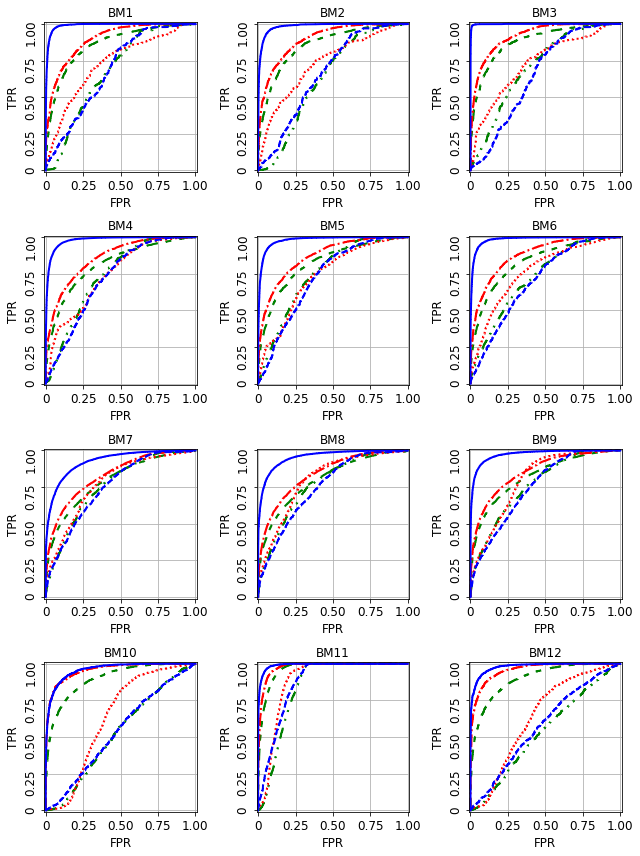

In [130]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(9, 12)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_tst_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_tst_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_trn_log = res_dict_trn_feat['log']["fpr_list"][iterator]
        tpr_list_trn_log = res_dict_trn_feat['log']["tpr_list"][iterator]
        fpr_list_trn_svm = res_dict_trn_feat['svm']["fpr_list"][iterator]
        tpr_list_trn_svm = res_dict_trn_feat['svm']["tpr_list"][iterator]
        fpr_list_trn_rfc = res_dict_trn_feat['rfc']["fpr_list"][iterator]
        tpr_list_trn_rfc = res_dict_trn_feat['rfc']["tpr_list"][iterator]
        fpr_list_trn_ada = res_dict_trn_feat['ada']["fpr_list"][iterator]
        tpr_list_trn_ada = res_dict_trn_feat['ada']["tpr_list"][iterator]
        fpr_list_trn_res = res_dict_trn_feat['res']["fpr_list"][iterator]
        tpr_list_trn_res = res_dict_trn_feat['res']["tpr_list"][iterator]
        fpr_list_trn_cnn = res_dict_trn_feat['cnn']["fpr_list"][iterator]
        tpr_list_trn_cnn = res_dict_trn_feat['cnn']["tpr_list"][iterator]
        fpr_list_tst_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_tst_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_tst_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_tst_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_tst_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_tst_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_tst_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_tst_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_tst_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_tst_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_tst_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_tst_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_trn_log, tpr_list_trn_log, 'g', 
                        linestyle=(0, (6, 4, 3, 4, 3, 5)),  linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_log, tpr_list_tst_log, 'g', 
                        linestyle=(0, (6, 4, 1, 4, 1, 5)), linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_rfc, tpr_list_trn_rfc, 'r-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_rfc, tpr_list_tst_rfc, 'r:', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_res, tpr_list_trn_res, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_res, tpr_list_tst_res, 'b--', linewidth = 2.0)
        ax[ii, jj].set_title(f'BM{int(pat_key[-2:])}', fontsize = 12)
        ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        #ax[ii,jj].set_xlim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_xticks([0.50, 0.75, 1.00])
        #ax[ii,jj].set_xticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].tick_params(axis='y', rotation=90)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    #plt.figlegend(["LR Train", "LR Valid", "RFC Train", "RFC Valid", "ResNet Train", "ResNet Valid"], \
    #             loc = 8, ncol=6, labelspacing=0.,
    #             bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v03.jpg", dpi=300)
    #plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v00.eps", dpi=300)
    plt.show()

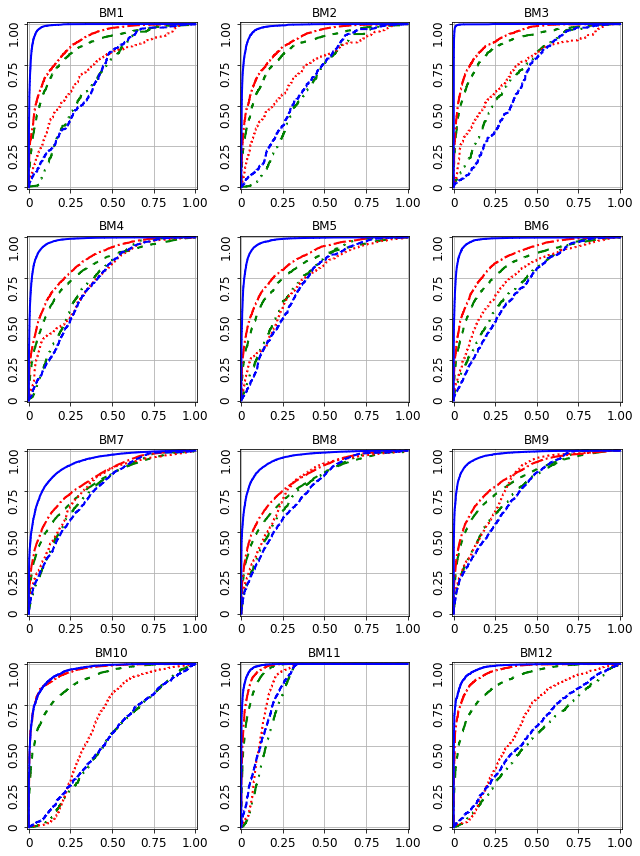

In [131]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(9, 12)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_tst_rfc = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_tst_rfc = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_trn_log = res_dict_trn_feat['log']["fpr_list"][iterator]
        tpr_list_trn_log = res_dict_trn_feat['log']["tpr_list"][iterator]
        fpr_list_trn_svm = res_dict_trn_feat['svm']["fpr_list"][iterator]
        tpr_list_trn_svm = res_dict_trn_feat['svm']["tpr_list"][iterator]
        fpr_list_trn_rfc = res_dict_trn_feat['rfc']["fpr_list"][iterator]
        tpr_list_trn_rfc = res_dict_trn_feat['rfc']["tpr_list"][iterator]
        fpr_list_trn_ada = res_dict_trn_feat['ada']["fpr_list"][iterator]
        tpr_list_trn_ada = res_dict_trn_feat['ada']["tpr_list"][iterator]
        fpr_list_trn_res = res_dict_trn_feat['res']["fpr_list"][iterator]
        tpr_list_trn_res = res_dict_trn_feat['res']["tpr_list"][iterator]
        fpr_list_trn_cnn = res_dict_trn_feat['cnn']["fpr_list"][iterator]
        tpr_list_trn_cnn = res_dict_trn_feat['cnn']["tpr_list"][iterator]
        fpr_list_tst_log = res_dict_tst_feat['log']["fpr_list"][iterator]
        tpr_list_tst_log = res_dict_tst_feat['log']["tpr_list"][iterator]
        fpr_list_tst_svm = res_dict_tst_feat['svm']["fpr_list"][iterator]
        tpr_list_tst_svm = res_dict_tst_feat['svm']["tpr_list"][iterator]
        fpr_list_tst_rfc = res_dict_tst_feat['rfc']["fpr_list"][iterator]
        tpr_list_tst_rfc = res_dict_tst_feat['rfc']["tpr_list"][iterator]
        fpr_list_tst_ada = res_dict_tst_feat['ada']["fpr_list"][iterator]
        tpr_list_tst_ada = res_dict_tst_feat['ada']["tpr_list"][iterator]
        fpr_list_tst_res = res_dict_tst_feat['res']["fpr_list"][iterator]
        tpr_list_tst_res = res_dict_tst_feat['res']["tpr_list"][iterator]
        fpr_list_tst_cnn = res_dict_tst_feat['cnn']["fpr_list"][iterator]
        tpr_list_tst_cnn = res_dict_tst_feat['cnn']["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_trn_log, tpr_list_trn_log, 'g', 
                        linestyle=(0, (6, 4, 3, 4, 3, 5)),  linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_log, tpr_list_tst_log, 'g', 
                        linestyle=(0, (6, 4, 1, 4, 1, 5)), linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_rfc, tpr_list_trn_rfc, 'r-.', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_rfc, tpr_list_tst_rfc, 'r:', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_trn_res, tpr_list_trn_res, 'b-', linewidth = 2.0)
        ax[ii, jj].plot(fpr_list_tst_res, tpr_list_tst_res, 'b--', linewidth = 2.0)
        ax[ii, jj].set_title(f'BM{int(pat_key[-2:])}', fontsize = 12)
        #ax[ii, jj].set_xlabel('FPR', fontsize = 12)
        #ax[ii, jj].set_ylabel('TPR', fontsize = 12)
        #ax[ii,jj].set_xlim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_xticks([0.50, 0.75, 1.00])
        #ax[ii,jj].set_xticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 12)
        ax[ii, jj].tick_params(axis='y', rotation=90)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    #print()
    #print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    #plt.figlegend(["LR Train", "LR Valid", "RFC Train", "RFC Valid", "ResNet Train", "ResNet Valid"], \
    #             loc = 8, ncol=6, labelspacing=0.,
    #             bbox_to_anchor=(0.25, -0.03, 0.5, 0.25),  fontsize = 12)
    fig.tight_layout()
    plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v04.jpg", dpi=300)
    #plt.savefig(fname = "fig04_mlspred_compr_roc_curves_v00.eps", dpi=300)
    plt.show()